In [1]:
#Workbench imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from workbench_version import * #load the model

from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

from ema_workbench import(ema_logging, perform_experiments)
from ema_workbench import MultiprocessingEvaluator

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


# Run experiments

In [2]:
#### LOAD ADAPTATION STRATEGIES ####
from mayors import *
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

In [3]:
from ema_workbench import(RealParameter,ScalarOutcome, Constant, BooleanParameter, CategoricalParameter, IntegerParameter,
                          Model, TimeSeriesOutcome)

model = Model('Rotty',function=run_model_workbench)

model.uncertainties = [CategoricalParameter('SLR',categories=['01','02','03','04',
                                                              '05','06','07','08','09']),
                       #CategoricalParameter('SLR',categories=['01','03','06','09']),
                       IntegerParameter('transient',lower_bound=0,upper_bound=19), #was 19
                       CategoricalParameter('Housing_market', #only for control of temp scalar outcome
                                            categories=['rational','boundedly_rational']),
                       CategoricalParameter('implementation_time', #only for small measure, large measure is calculated proportionally from it
                                categories=[4,5,7,8,9,10,11,12,13,14])]


model.levers = [CategoricalParameter('Mayor',categories=allMayors)]

model.outcomes = [#TimeSeriesOutcome('HP_hp_t_obj'),
                  #TimeSeriesOutcome('HP_hp_t_sub'),
                  #TimeSeriesOutcome('CC_hp_t_obj'),
                  #TimeSeriesOutcome('CC_hp_t_sub'),
                  ScalarOutcome('HP_hp_2200_obj'),
                  ScalarOutcome('HP_hp_2200_sub'),
                  ScalarOutcome('CC_hp_2200_obj'),
                  ScalarOutcome('CC_hp_2200_sub'),
                  ScalarOutcome('HP_first_SETP'),
                  ScalarOutcome('CC_first_SETP'),]

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

#experiments, outcomes = perform_experiments(models=model,scenarios=160,policies=4)
#results = experiments, outcomes
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=3600,policies=4)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3600 scenarios * 4 policies * 1 model(s) = 14400 experiments
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 4320 cases completed
[MainProcess/INFO] 5760 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8640 cases completed
[MainProcess/INFO] 10080 cases completed
[MainProcess/INFO] 11520 cases completed
[MainProcess/INFO] 12960 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [9]:
experiments, outcomes = results

### Save results

In [5]:
from ema_workbench import save_results

foldername = "temp"
subfolder = "experiments"
target = os.path.join(foldername,subfolder)

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

if not os.path.exists(foldername):
    os.mkdir(foldername)
    if not os.path.exists(target):
        os.mkdir(target)

save_results(results,os.path.join(target,date + '_EMA_experiments.tar.gz'))

[MainProcess/INFO] results saved successfully to D:\Python\Urban-SETP\temp\experiments\2020_10_15_EMA_experiments.tar.gz


### Load results

In [6]:
from ema_workbench import load_results

foldername = "temp"
subfolder = "experiments"
target = os.path.join(foldername,subfolder)

#experiments, outcomes = load_results(os.path.join(target,"2020_10_6_EMA_experiments.tar.gz"))
experiments, outcomes = load_results(os.path.join(target,"2020_10_15_EMA_experiments.tar.gz"))

[MainProcess/INFO] results loaded succesfully from D:\Python\Urban-SETP\temp\experiments\2020_10_15_EMA_experiments.tar.gz


In [7]:
experiments.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario,policy,model
0,rational,6,5,19.0,R. Active,0,0,Rotty
1,rational,6,7,13.0,R. Active,1,0,Rotty
2,rational,2,5,5.0,R. Active,2,0,Rotty
3,boundedly_rational,7,11,11.0,R. Active,3,0,Rotty
4,boundedly_rational,5,4,15.0,R. Active,4,0,Rotty


In [8]:
experiments2 = experiments.drop(['policy','model'],axis=1)
experiments2.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
0,rational,6,5,19.0,R. Active,0
1,rational,6,7,13.0,R. Active,1
2,rational,2,5,5.0,R. Active,2
3,boundedly_rational,7,11,11.0,R. Active,3
4,boundedly_rational,5,4,15.0,R. Active,4


In [9]:
experiments3 = experiments2.copy()
map_house_market = {'rational' : 0, 
             'boundedly_rational' :1}
#map_mayor = {'H. Economicus': 0,
#             'Sentiment' : 1,
#             'R. Active' : 2,
#             'Lawkeeper' : 3}
map_mayor = {'H. Economicus': 1,
             'Sentiment' : 2,
             'R. Active' : 0,
             'Lawkeeper' : 3}

experiments3['Housing_market'].replace(map_house_market,inplace=True)
experiments3['Mayor'].replace(map_mayor,inplace=True)
experiments3[['Housing_market', 'SLR', 'transient', 'Mayor']].astype('float')
experiments3.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
0,0,6,5,19.0,0,0
1,0,6,7,13.0,0,1
2,0,2,5,5.0,0,2
3,1,7,11,11.0,0,3
4,1,5,4,15.0,0,4


In [10]:
pd.DataFrame(outcomes)['CC_first_SETP'].unique()

array([9999, 2111, 2138, 2094, 2097, 2096, 2086, 2195, 2120, 2085, 2105,
       2128, 2098, 2205, 2102, 2123, 2156, 2149, 2088, 2079, 2110, 2095,
       2104, 2141, 2084, 2134, 2113, 2146, 2093, 2163, 2092, 2115, 2080,
       2077, 2192, 2082, 2099, 2076, 2126, 2161, 2154, 2089, 2145, 2173,
       2171, 2186, 2151, 2137, 2078, 2147, 2091, 2199, 2103, 2196, 2184,
       2114, 2122, 2108, 2189, 2100, 2101, 2219, 2150, 2121, 2087, 2201,
       2178, 2210, 2083, 2117, 2172, 2107, 2158, 2106, 2139, 2187, 2165,
       2109, 2177, 2182, 2148, 2180, 2181, 2130, 2152, 2129, 2112, 2116,
       2216, 2135, 2188, 2198, 2215, 2155, 2185, 2168, 2132, 2197, 2193],
      dtype=int64)

# Scenario discovery with first_SETP indicator

What is SD doing? It finds subspaces in the input space, where high concentrations of outcomes of interest are found. In our case: we search for points where the first SETP in the City Centre happens before the year 2200.

In [11]:
%matplotlib inline

from ema_workbench.analysis import prim
x = experiments3
y = outcomes['CC_first_SETP'] < 2200
prim_alg = prim.Prim(x,y,threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 14400 points remaining, containing 3454 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0625, coverage: 0.26056745801968734, density: 1.0 restricted_dimensions: 5


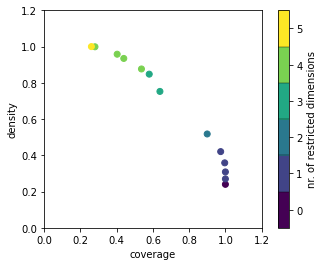

In [12]:
%matplotlib inline
box1.show_tradeoff()
plt.show()

#Eerste puntje: Mayor 0-2: dus uitsluiten van Mayor Lawkeeper
#Tweede puntje: Mayor 1-2: dus uitsluiten van Mayor Sentiment
#Derde puntje (box): 3: dus uitsluiten van rationele woningmarkt
# 4 tot 6: beperken zeespiegelscenario

0
1
2
3
4
5
6
7
8
9
10


C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:442: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(top=-0.5, bottom=nr_unc - 0.5)


11
12


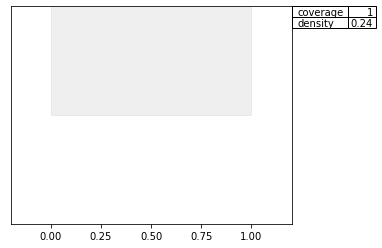

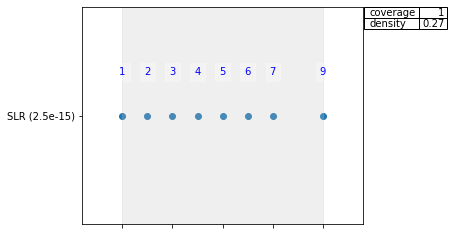

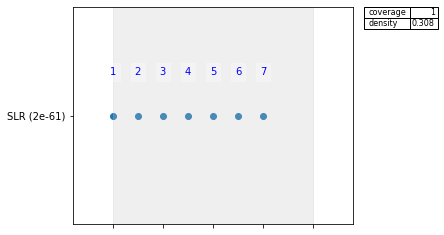

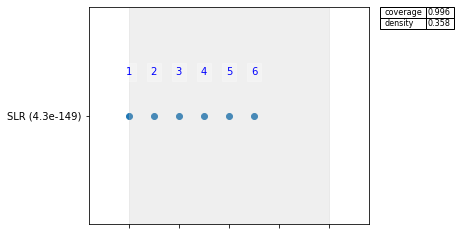

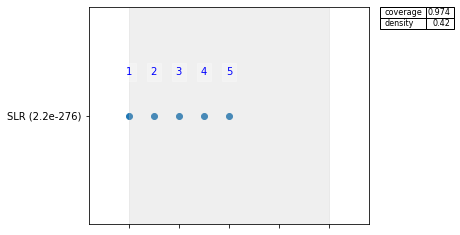

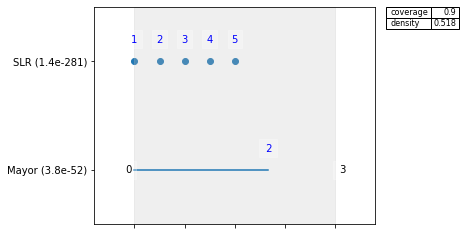

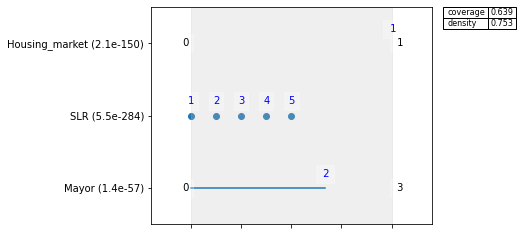

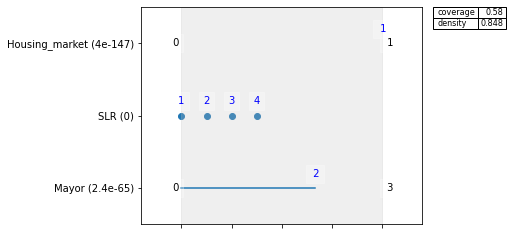

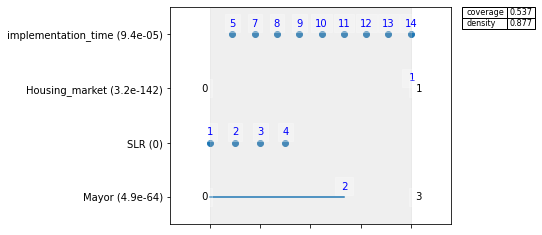

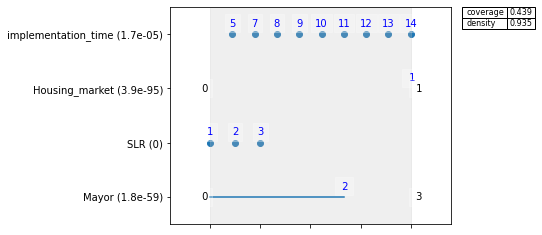

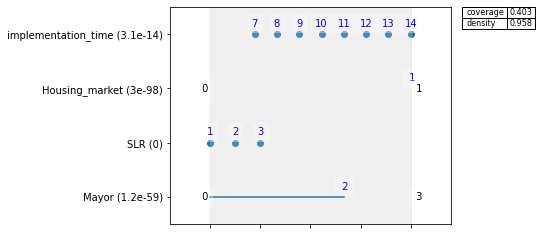

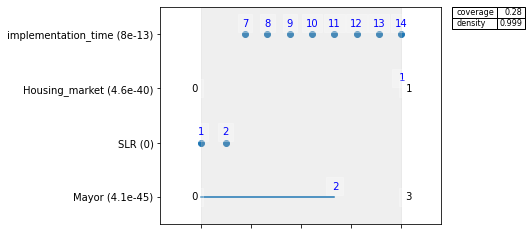

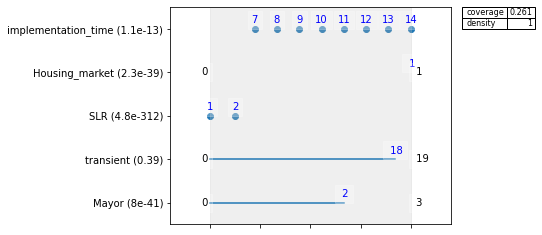

In [13]:
for i in range(0,len(box1.box_lims)):
    print(i)
    box1.inspect(i,style='graph')

Density = hoeveel procent van de punten in de box is een SETP?
Coverage = hoeveel procent van alle SETPs zit in de box?

### Feature scoring
Feature scoring is een soort gevoeligheidsanalyse. Die doe ik hier op 6 verschillend output indicatoren.

HP_hp_2200_obj : de huizenprijs in de Heijplaat, volgens een rationele huizenmarkt, in het jaar 2200

HP_hp_2200_sub : de huizenprijs in de Heijplaat, volgens een boundedly rational housing market, in het jaar 2200

CC__           : idem voor het stadscentrum

CC__           : idem voor het stadscentrum

HP_first_SETP  : Heijplaat: het jaartal waarin de eerste SETP plaatsvindt (nu alleen op basis van criterium 'rapid change')

CC_first_SETP  : City Centre: idem

In [35]:
experiments3

,Housing_market,SLR,implementation_time,transient,Mayor
0,0,8,7,5.0,1
1,0,9,7,17.0,1
2,0,5,9,0.0,1
3,1,2,11,4.0,1
4,1,2,14,19.0,1
...,...,...,...,...,...
14395,1,5,7,1.0,0
14396,1,2,10,9.0,0
14397,1,4,13,6.0,0
14398,1,4,5,8.0,0


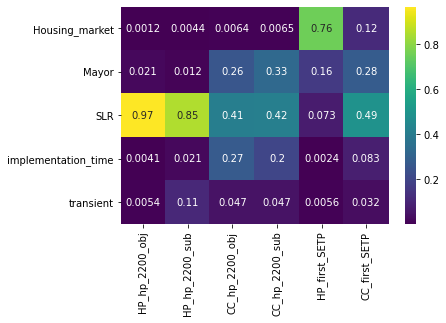

In [36]:
from ema_workbench.analysis import feature_scoring
x = experiments3
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

What can we learn from the above? (col 1-4)
 - For the survival (~house price) of the Heijplaat, the sea level rise scenario explains everything (independent of which housing market)
 - For the city centre, it is first the Mayor (0.47), then SLR and Transient
 
For the timing of the SETP:
 - In the Heijplaat the assumptions about the Housing market are everything, the Mayor is a little bit.
 - In the city centre, many factors play a role. But is is mainly the Mayor (0.48), then the SLR scenario (0.31), then the choice for the housing market (0.12)

### Dimensional stacking: 
This is a more visual approach to scenario discovery, indicating which combinations of input factors (X) explain outcome metrics of interest (M).

### What explains if SETPs in the City Centre occur before 2200?

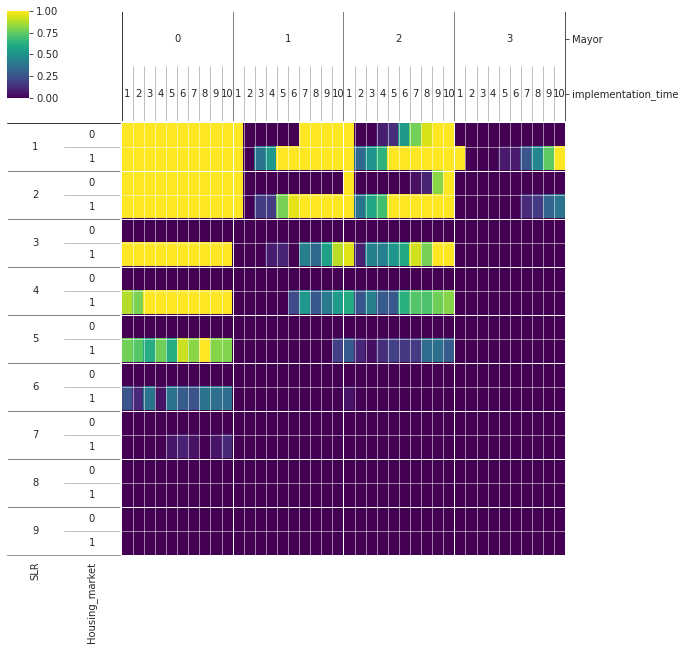

In [62]:
from ema_workbench.analysis import dimensional_stacking

x = experiments3
y = outcomes['CC_first_SETP'] <2200
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=4,categories=True)

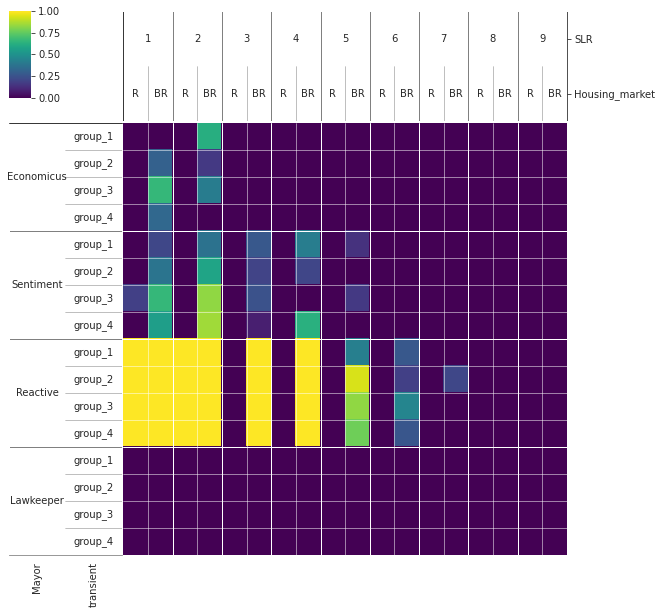

In [7]:
from ema_workbench.analysis import dimensional_stacking

x = experiments2.drop('policy',axis=1)
y = outcomes['CC_first_SETP'] <2200
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=4,categories=True)
#Get control over some labels
fig._axstack._elements[1][1][1].texts[0]._text = 'Economicus'
for i in range(1,5):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(i)
fig._axstack._elements[1][1][1].texts[5]._text = 'Sentiment'
j = 1
for i in range(6,10):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(j)
    j += 1
fig._axstack._elements[1][1][1].texts[10]._text = 'Reactive'
j = 1
for i in range(11,15):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(j)
    j += 1
fig._axstack._elements[1][1][1].texts[15]._text = 'Lawkeeper'
j = 1
for i in range(16,20):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(j)
    j += 1
    
#x-labels:
for i, text in enumerate(fig._axstack._elements[2][1][1].texts):
    if i%3 == 1:
        text._text = 'R'
    elif i%3 == 2:
        text._text = 'BR'
    #print(i,i//3,i%3,text._text)

In [8]:
foldername = "Visualisations"

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

target = os.path.join(foldername,date)

if not os.path.exists(foldername):
    os.mkdir(foldername)
    if not os.path.exists(target):
        os.mkdir(target)

fig.savefig(os.path.join(target,"Dimensional_stacking_crit_1.png"),bbox_inches="tight",dpi=200)

What can we learn from the above picture?

Under Mayor 2 *Reactive*, the concentration of SETPs is the highest. Under SLR scenario 1 and 2 they happen in both type of housing market. From SLR scenario 3 to 7 they only happen in a boundedly rational housing market. 

Under Mayor 1 *Sentiment*, tipping points may still occur in a boundedly rational housing market, mainly under SLR scenario 1-4. Here, the transient scenario also starts to play a mayor role.

Under Mayor 3 *Economicus*, there stil is a small likelihood of tipping points in a boundedly rational housing market, combined with the most extreme sea level rise scenario.

Even in the most extreme SLR scenario 1, tipping points can be still be avoided under mayor *Lawkeeper*

In [95]:
#Retrieve some specific experiments from the above run

### Dimensional stacking: Heijplaat tips before 2100

[MainProcess/INFO] model dropped from analysis because only a single category


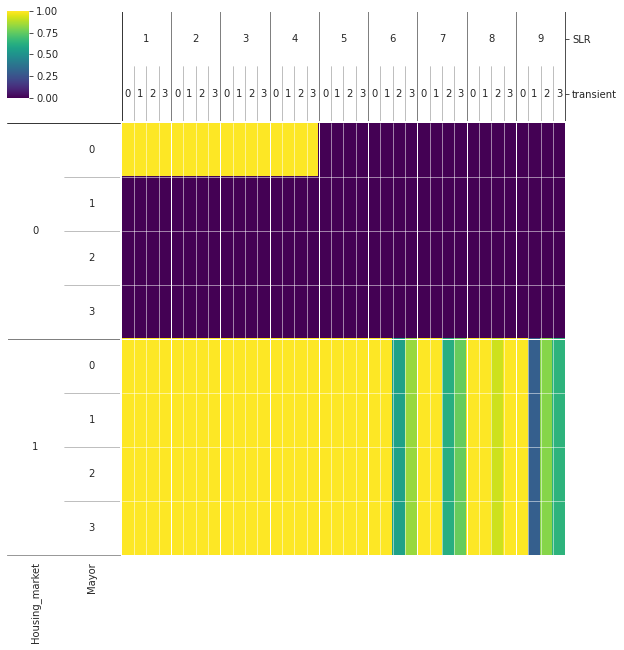

In [35]:
x = experiments2.drop('policy',axis=1)
y = outcomes['HP_first_SETP'] <2100
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4,categories=True)

Interpretation: in a boundedly rational housing market, there will almost certainly be a tipping point before 2100 in the Heijplaat. With a low degree of SLR (scenario 6-9), the city might survive, but this depends on the transient storm surge scenarios.

Note that this does not necessarily mean that in the other scenarios the house price does not go to zero!!!! It just indicates that this does not go ABRUPT, tipping-point like.

In a rational housing market, there will only be tipping points under very high sea level rise scenarios and Mayor 0 (Economicus).

### Parallel coordinate plots

In [38]:
from ema_workbench.analysis import parcoords
data = results.loc[:, [o.name for o in model.outcomes]]

AttributeError: 'tuple' object has no attribute 'loc'

In [51]:
exp_par = experiments.copy().drop(['policy','model','scenario'],axis=1)
exp_par['SLR'] = exp_par['SLR'].astype('float')
exp_par

,Housing_market,SLR,transient,Mayor
0,boundedly_rational,6.0,18.0,H. Economicus
1,rational,6.0,19.0,H. Economicus
2,rational,4.0,12.0,H. Economicus
3,rational,1.0,5.0,H. Economicus
4,rational,2.0,7.0,H. Economicus
...,...,...,...,...
3995,rational,8.0,9.0,Lawkeeper
3996,rational,3.0,5.0,Lawkeeper
3997,boundedly_rational,5.0,13.0,Lawkeeper
3998,boundedly_rational,7.0,1.0,Lawkeeper


In [59]:
limits = parcoords.get_limits(exp_par)
limits

,Housing_market,SLR,transient,Mayor
0,"{boundedly_rational, rational}",1.0,0.0,"{Lawkeeper, Sentiment, R. Active, H. Economicus}"
1,"{boundedly_rational, rational}",9.0,19.0,"{Lawkeeper, Sentiment, R. Active, H. Economicus}"


In [60]:
paraxes = parcoords.ParallelAxes(limits)

AttributeError: 'DataFrame' object has no attribute 'ix'

### Regional sensitivity analysis

In [124]:
experiments2['SLR'] = experiments2['SLR'].astype('float')

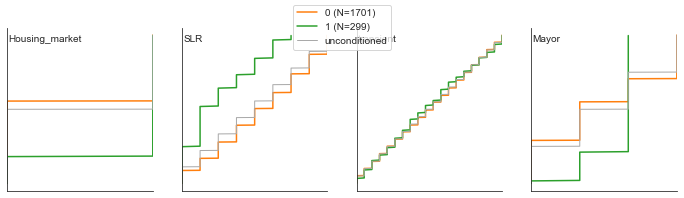

In [125]:
sns.set_style('white')

# model is the same across experiments
x = experiments2.copy()
x = x.drop(['model','policy'], axis=1)
y = outcomes['CC_first_SETP'] <2200
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

# Sobol-indices (does not work)

In [36]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=['Sentiment'],
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

[MainProcess/INFO] pool started
[MainProcess/INFO] terminating pool


AttributeError: 'NoneType' object has no attribute 'sample'

In [ ]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['max_P'],
                   calc_second_order=True, print_to_console=False)

# Old stuff

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "
[MainProcess/INFO] no time dimension found in results


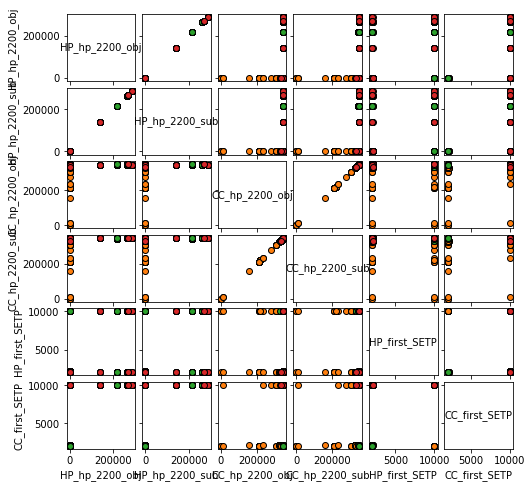

In [7]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

In [8]:
from ema_workbench.analysis import feature_scoring

x = pd.DataFrame(experiments)
y = pd.DataFrame(outcomes)

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

TypeError: '<' not supported between instances of 'Reactive' and 'Lawkeeper'

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

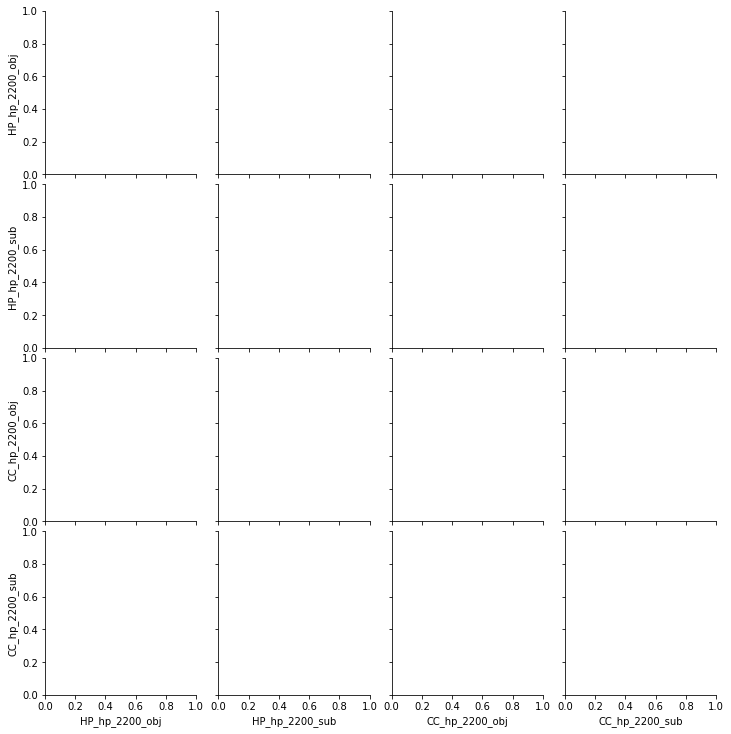

In [21]:
policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

In [13]:
experiments.Mayor.unique()

array([<mayors.Reactive object at 0x000001D502353A60>,
       <mayors.Lawkeeper object at 0x000001D502353E80>], dtype=object)

In [14]:
experiments2 = experiments.copy()
experiments2['SLR']=  experiments2['RCP'] + "_" + experiments2['collapse'].map(str) + "_"  + experiments2['PDF'].map(str)
experiments2

KeyError: 'RCP'

In [92]:
slr_scenarios = experiments2['SLR']
#unique = np.unique(slr_scenarios)
#for i, slr in enumerate(unique):
#     experiments2.loc[slr_scenarios==slr, 'SLR'] = str(i) #replace  by integer
data = pd.DataFrame(outcomes)
data['slr_scenarios'] = slr_scenarios
#data['slr_scenarios']
data.iloc[:,4]

0        RCP85_True_50
1        RCP85_True_17
2       RCP26_False_17
3       RCP26_False_17
4        RCP85_True_17
             ...      
3995     RCP26_True_17
3996    RCP26_False_50
3997    RCP26_False_17
3998    RCP85_False_50
3999     RCP26_True_50
Name: slr_scenarios, Length: 4000, dtype: object

In [98]:
data.sort_values(by='slr_scenarios',inplace=True)

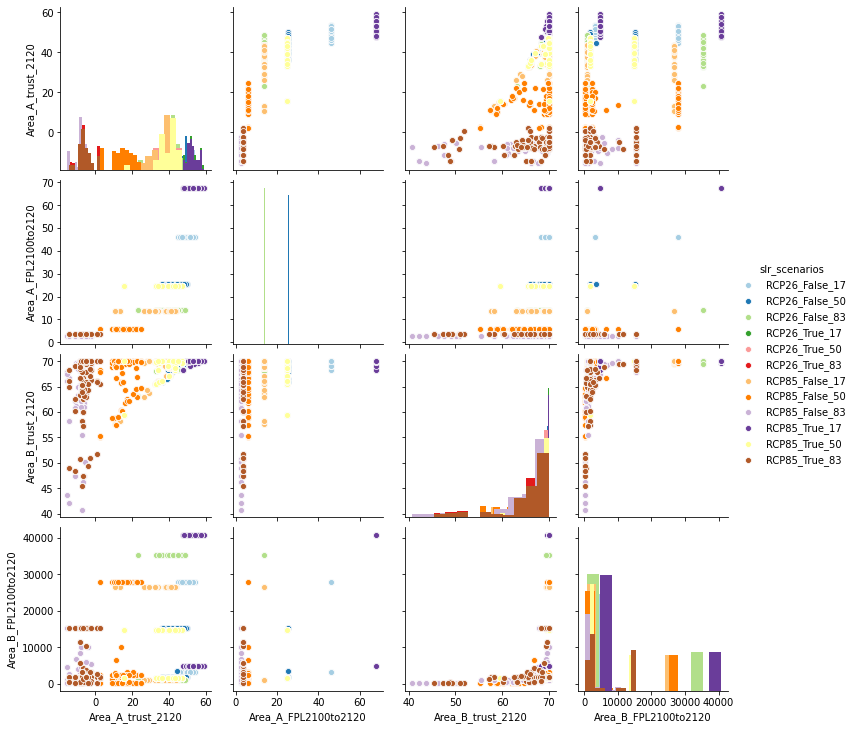

In [104]:
sns.pairplot(data, hue='slr_scenarios',vars=list(outcomes.keys()),diag_kind='hist',palette='Paired')

In [ ]:
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

[MainProcess/INFO] no time dimension found in results


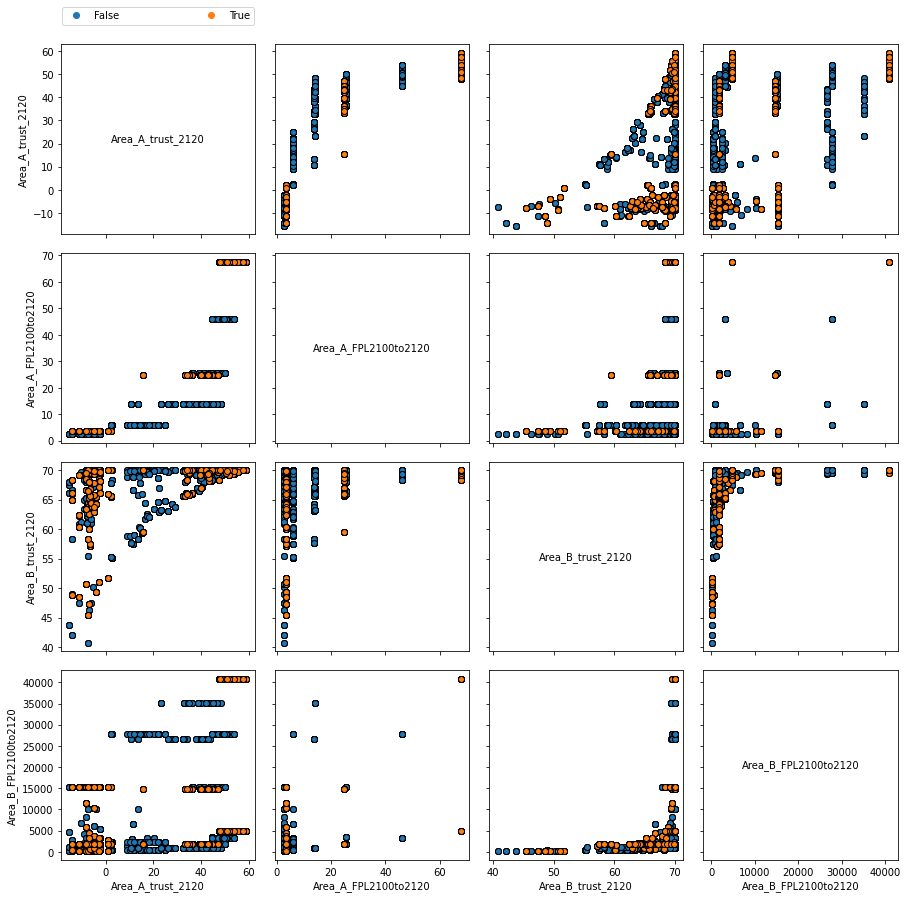

In [28]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='collapse',
                                         legend=True)
fig.set_size_inches(15,15)
plt.show()

In [22]:
outcomes

{'Area_A_trust_2120': array([45.08716481, 55.53645285, 51.64224843, ..., 53.90578306,
        11.96904438, 34.07296084]),
 'Area_A_FPL2100to2120': array([24.76569913, 67.62419361, 46.17610852, ..., 46.17610852,
         5.92469669, 24.76569913]),
 'Area_B_trust_2120': array([69.92675009, 69.64431336, 69.1611392 , ..., 69.45103983,
        69.81192545, 65.99996165]),
 'Area_B_FPL2100to2120': array([1741.85920216, 4818.09541286, 3278.66657571, ..., 3278.66657571,
        2403.91616273, 1741.85920216])}

In [26]:
from ema_workbench.analysis import feature_scoring
x = experiments
y = outcomes



AttributeError: module 'ema_workbench.analysis.feature_scoring' has no attribute 'CLASSIFICATION'